In [35]:
from data_common.notebook import *
import requests
import os
from urllib.parse import quote, urlencode

In [36]:
def get_lsoa(postcode: str) -> str:

    host = "https://mapit.mysociety.org"

    headers = {"X-Api-Key": os.environ["MAPIT_API"]}
    postcode_url = host + f"/postcode/{quote(postcode)}"

    s = requests.Session()
    s.mount(host, requests.adapters.HTTPAdapter(max_retries=5))
    r = s.get(postcode_url, headers=headers)
    mapit_data = r.json()

    lsoa = list(
        filter(lambda area: area["type"] == "OLF", mapit_data["areas"].values())
    )[0]
    code = list(lsoa["codes"].values())[0]
    return code

# Housing data notebook

This is a notebook for the mySociety housing energy prototype week, exploring the availability of data. 

This is testing how easy it is to take a postcode, run it against MapIt, and then get local breakdowns of:

* Age of construction
* Type of housing
* Wall Type (From EPC data)

In principle this data is available through the VOA data and EPC data - but this has already been [combined by carbon.place for England and Wales](https://www.carbon.place/data/). 

In [37]:
df = pd.read_csv(Path("..", "data", "raw", "external", "PBCC_LSOA_data.csv"))

types = [
    "Whole_House_Detached",
    "Whole_House_Semi",
    "Whole_House_Terraced",
    "Flat_PurposeBuilt",
    "Flat_Converted",
    "Flat_Commercial",
]

construction = [
    "pP1900",
    "p1900_18",
    "p1919_29",
    "p1930_39",
    "p1945_54",
    "p1955_64",
    "p1965_72",
    "p1973_82",
    "p1983_92",
    "p1993_99",
    "p2000_09",
    "p2010_15",
]

wall = [
    "wall_verygood",
    "wall_good",
    "wall_average",
    "wall_poor",
    "wall_verypoor",
    "wall_other",
]

keep = (
    [
        "LSOA11",
        "epc_score_avg",
    ]
    + wall
    + construction
    + types
)

In [38]:
housing_percentages = (
    df[["LSOA11"] + construction]
    .set_index("LSOA11")
    .pipe(lambda df: df.div(df.sum(axis=1), axis=0))  # row percentages
    .reset_index()
    .melt("LSOA11", var_name="period", value_name="percentage")
    .assign(
        period=lambda df: df["period"].apply(
            lambda x: x.replace("p", "").replace("P", "Pre ").replace("_", "-")
        )
    )
)

In [39]:
housing_type = (
    df[["LSOA11"] + types]
    .set_index("LSOA11")
    .pipe(lambda df: df.div(df.sum(axis=1), axis=0))  # row percentages
    .reset_index()
    .melt("LSOA11", var_name="period", value_name="percentage")
    .assign(
        period=lambda df: df["period"].apply(
            lambda x: x.replace("_", " ").replace("PurposeBuilt", "Purpose Built")
        )
    )
)

In [40]:
wall_score = (
    df[["LSOA11"] + wall]
    .set_index("LSOA11")
    .pipe(lambda df: df.div(df.sum(axis=1), axis=0))  # row percentages
    .reset_index()
    .melt("LSOA11", var_name="period", value_name="percentage")
    .assign(
        period=lambda df: df["period"].apply(
            lambda x: x.replace("_", " ").replace("wall ", "").replace("very", "very ")
        )
    )
)

In [41]:
postcode = "CH63 0EF"
lsoa = get_lsoa(postcode)
f"The LSOA for postcode '{postcode}' is: '{lsoa}'"

"The LSOA for postcode 'CH63 0EF' is: 'E01007148'"

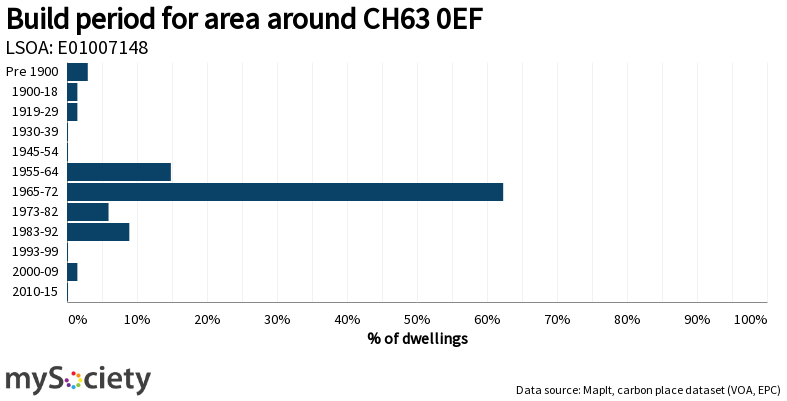

In [42]:
d = housing_percentages.loc[lambda df: df["LSOA11"] == lsoa]


chart = (
    Chart(d)
    .mark_bar()
    .encode(
        y=alt.Y("period", sort=None, title=""),
        x=alt.X(
            "percentage",
            title="% of dwellings",
            scale=alt.Scale(domain=[0, 1]),
            axis=alt.Axis(format="%"),
        ),
    )
    .properties(
        title=f"Build period for area around {postcode}",
        subtitle=f"LSOA: {lsoa}",
        logo=True,
        caption="Data source: MapIt, carbon place dataset (VOA, EPC)",
    )
)

chart.display()
chart.save(Path("..", "data", "build_period.png"), scale_factor=2)

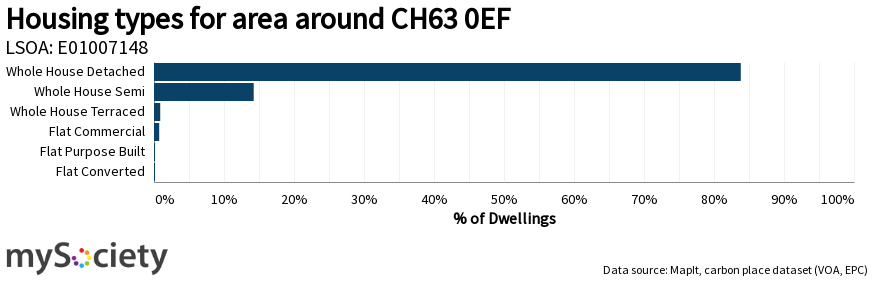

In [43]:
d = housing_type.loc[lambda df: df["LSOA11"] == lsoa]

chart = (
    Chart(d)
    .mark_bar()
    .encode(
        y=alt.Y("period", sort="-x", title=""),
        x=alt.X(
            "percentage",
            title="% of Dwellings",
            scale=alt.Scale(domain=[0, 1]),
            axis=alt.Axis(format="%"),
        ),
    )
    .properties(
        title=f"Housing types for area around {postcode}",
        subtitle=f"LSOA: {lsoa}",
        logo=True,
        caption="Data source: MapIt, carbon place dataset (VOA, EPC)",
    )
)

chart.display()
chart.save(Path("..", "data", "build_type.png"), scale_factor=2)

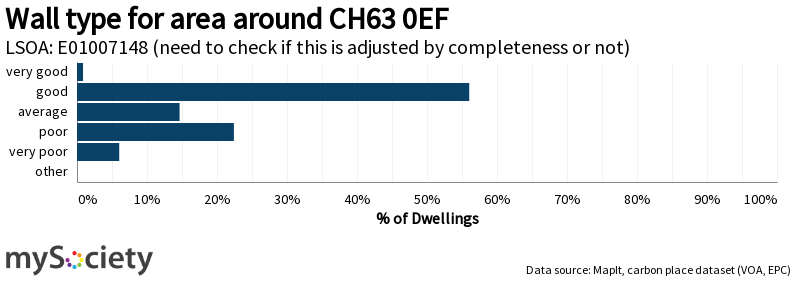

In [44]:
d = wall_score.loc[lambda df: df["LSOA11"] == lsoa]
d["period_ranking"] = d["period"].map(
    {"very good": 0, "good": 1, "average": 2, "poor": 3, "very poor": 4, "other": 5}
)

chart = (
    Chart(d)
    .mark_bar()
    .encode(
        y=alt.Y("period", sort=None, title=""),
        x=alt.X(
            "percentage",
            title="% of Dwellings",
            scale=alt.Scale(domain=[0, 1]),
            axis=alt.Axis(format="%"),
        ),
    )
    .properties(
        title=f"Wall type for area around {postcode}",
        subtitle=f"LSOA: {lsoa} (need to check if this is adjusted by completeness or not)",
        logo=True,
        caption="Data source: MapIt, carbon place dataset (VOA, EPC)",
    )
)

chart.display()
chart.save(Path("..", "data", "wall_score.png"), scale_factor=2)